In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import networkx as nx

plt.style.use('seaborn-v0_8')
sns.set_theme()

# --- Load and Prepare Data ---
oracle_cols = ['Start Timestamp', 'End Timestamp', 'Total Time in Seconds', 
               'Response Time in Seconds', 'Number of DB Queries', 'User Name',
               'Subject Area Name', 'Dashboard Name', 'Success Flag']
oracle_df = pd.read_csv('newOracle.csv', usecols=oracle_cols, low_memory=False)
oracle_df['Start Timestamp'] = pd.to_datetime(oracle_df['Start Timestamp'])
oracle_df['End Timestamp'] = pd.to_datetime(oracle_df['End Timestamp'])
oracle_df['Hour'] = oracle_df['Start Timestamp'].dt.hour
oracle_df['Day_of_Week'] = oracle_df['Start Timestamp'].dt.day_name()

tableau_df = pd.read_csv('tableau_logs.csv', encoding='utf-16', sep='\t', 
                         engine='python', on_bad_lines='skip')
tableau_df['created_at_local'] = pd.to_datetime(tableau_df['created_at_local'])
tableau_df['Hour'] = tableau_df['created_at_local'].dt.hour
tableau_df['Day_of_Week'] = tableau_df['created_at_local'].dt.day_name()

In [8]:
# --- Analyze User Patterns ---
oracle_user_stats = oracle_df.groupby('User Name').agg({
    'Total Time in Seconds': ['count', 'mean'],
    'Response Time in Seconds': 'mean',
    'Number of DB Queries': 'sum',
    'Success Flag': 'mean'
}).round(2)

avg_success_rate = oracle_df['Success Flag'].mean() * 100
tableau_user_stats = tableau_df.groupby('username').agg({
    'Name (Hist Views)': 'count',
    'Name (Hist Workbooks)': 'nunique'
}).round(2)

oracle_hourly_users = oracle_df.groupby(['Hour', 'User Name']).size().reset_index(name='count')
tableau_hourly_users = tableau_df.groupby(['Hour', 'username']).size().reset_index(name='count')

# --- Analyze Content Usage ---
oracle_content = oracle_df.groupby('Dashboard Name').agg({
    'User Name': 'nunique',
    'Total Time in Seconds': ['count', 'mean'],
    'Success Flag': 'mean'
}).round(2)

tableau_content = tableau_df.groupby('Name (Hist Views)').agg({
    'username': 'nunique',
    'Distinct Users': 'sum'
}).round(2)

oracle_hourly_content = oracle_df.groupby(['Hour', 'Dashboard Name']).size().reset_index(name='count')
tableau_hourly_content = tableau_df.groupby(['Hour', 'Name (Hist Views)']).size().reset_index(name='count')

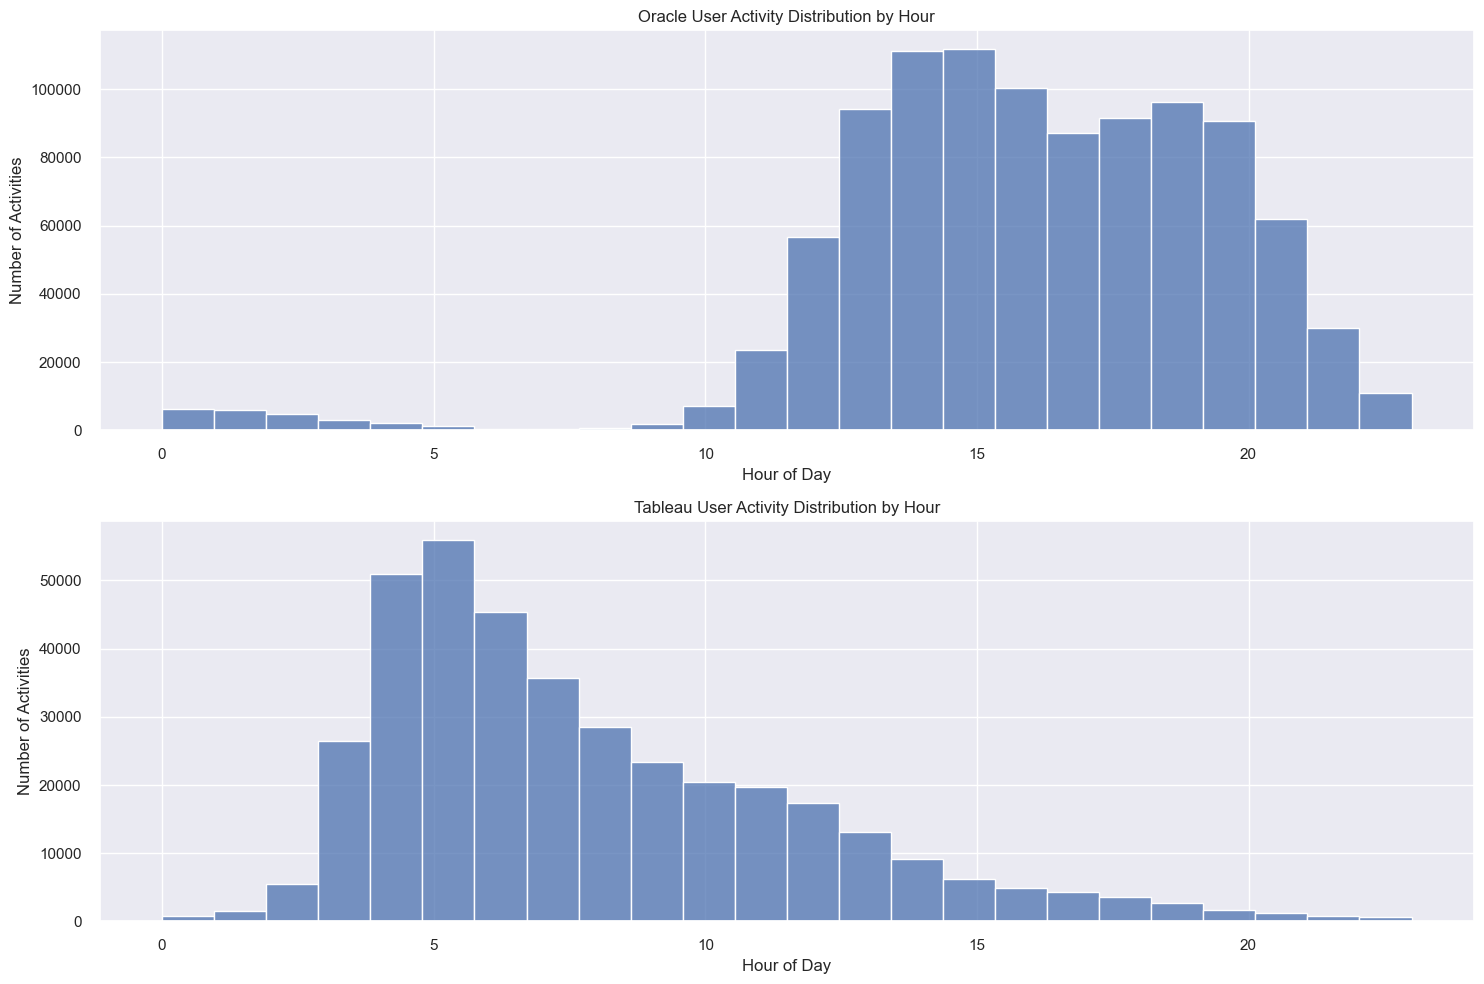

In [9]:
# --- User Activity Distribution Plot ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
sns.histplot(data=oracle_hourly_users, x='Hour', weights='count', bins=24)
plt.title('Oracle User Activity Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Activities')

plt.subplot(2, 1, 2)
sns.histplot(data=tableau_hourly_users, x='Hour', weights='count', bins=24)
plt.title('Tableau User Activity Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Activities')

plt.tight_layout()
plt.show()

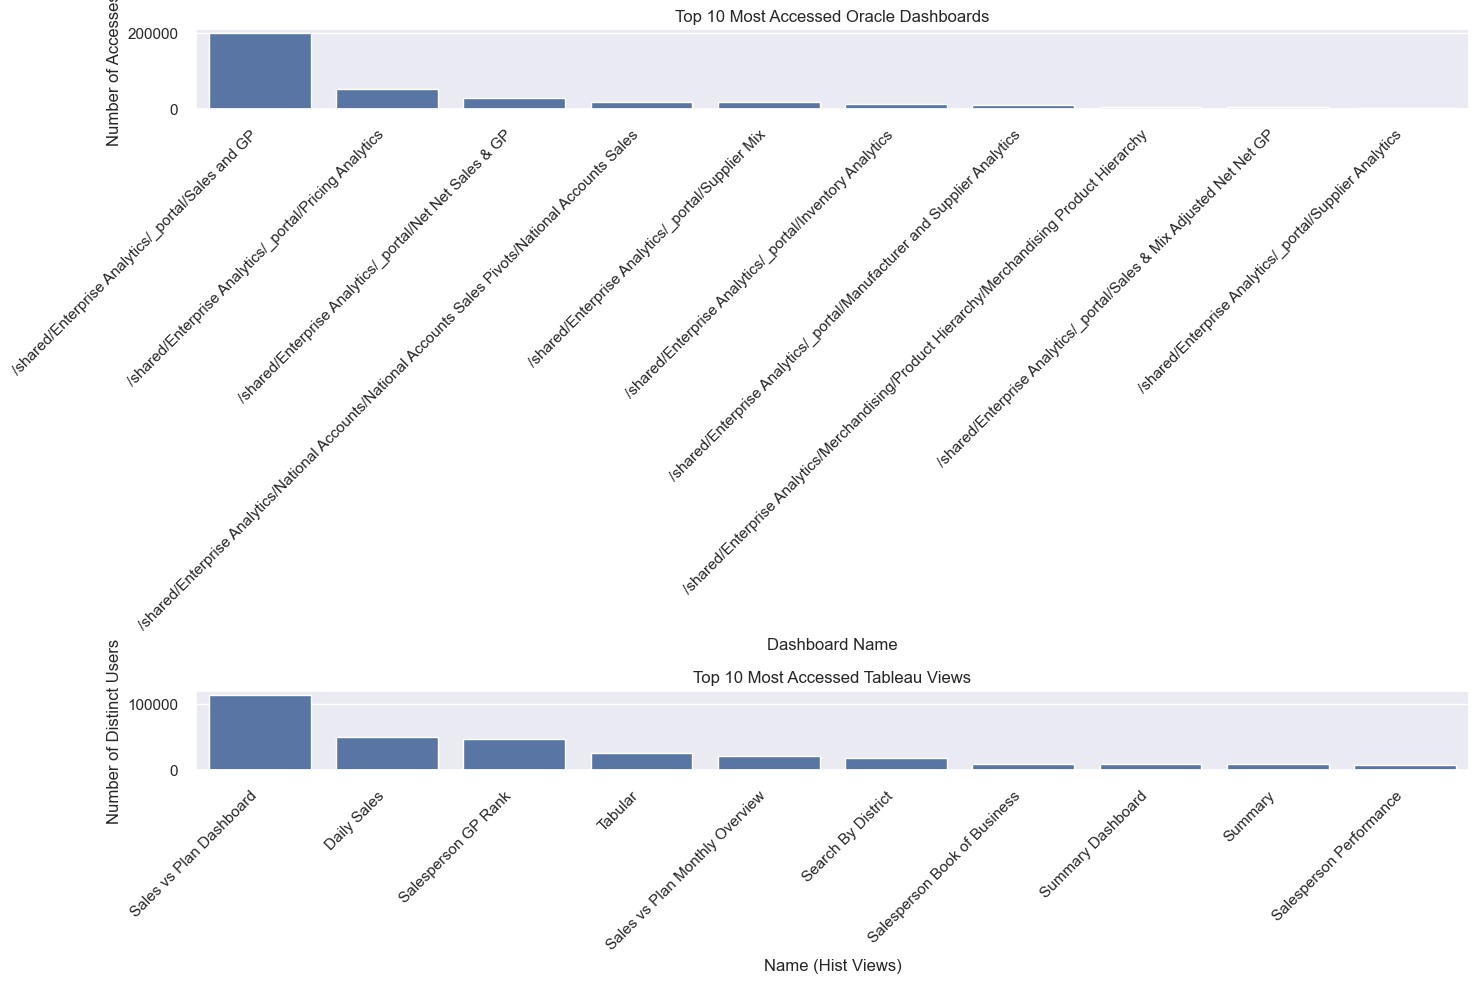

In [10]:
# --- Content Usage Patterns Plot ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
top_oracle_content = oracle_content.sort_values(('Total Time in Seconds', 'count'), ascending=False).head(10)
sns.barplot(x=top_oracle_content.index, 
            y=top_oracle_content[('Total Time in Seconds', 'count')])
plt.title('Top 10 Most Accessed Oracle Dashboards')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Accesses')

plt.subplot(2, 1, 2)
top_tableau_content = tableau_content.sort_values('Distinct Users', ascending=False).head(10)
sns.barplot(x=top_tableau_content.index, y=top_tableau_content['Distinct Users'])
plt.title('Top 10 Most Accessed Tableau Views')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Distinct Users')

plt.tight_layout()
plt.show()


In [11]:
# --- Summary Text Output ---
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

printmd("### Summary Statistics\n")
print(f"- Oracle: {len(oracle_user_stats)} unique users")
print(f"- Tableau: {len(tableau_user_stats)} unique users")
print(f"- Oracle average success rate: {avg_success_rate:.2f}%")

printmd("### Peak Usage Hours\n")
oracle_peak_hour = oracle_hourly_users.groupby('Hour')['count'].sum().idxmax()
tableau_peak_hour = tableau_hourly_users.groupby('Hour')['count'].sum().idxmax()
print(f"- Oracle peak hour: {oracle_peak_hour}:00")
print(f"- Tableau peak hour: {tableau_peak_hour}:00")

### Summary Statistics


- Oracle: 1351 unique users
- Tableau: 3952 unique users
- Oracle average success rate: 0.83%


### Peak Usage Hours


- Oracle peak hour: 15:00
- Tableau peak hour: 5:00


In [12]:
def analyze_time_periods(oracle_df, tableau_df):
    """Analyze specific time periods in detail"""
    periods = {
        'Morning_Rush': (6, 9),
        'Business_Hours': (9, 17),
        'Evening_Rush': (17, 20),
        'Night': (20, 6)
    }

    period_analysis = {}
    for period_name, (start_hour, end_hour) in periods.items():
        if start_hour > end_hour:
            oracle_mask = (oracle_df['Hour'] >= start_hour) | (oracle_df['Hour'] < end_hour)
            tableau_mask = (tableau_df['Hour'] >= start_hour) | (tableau_df['Hour'] < end_hour)
        else:
            oracle_mask = (oracle_df['Hour'] >= start_hour) & (oracle_df['Hour'] < end_hour)
            tableau_mask = (tableau_df['Hour'] >= start_hour) & (tableau_df['Hour'] < end_hour)

        oracle_period = oracle_df[oracle_mask]
        oracle_metrics = {
            'total_queries': len(oracle_period),
            'avg_response_time': oracle_period['Response Time in Seconds'].mean(),
            'total_db_queries': oracle_period['Number of DB Queries'].sum(),
            'unique_users': oracle_period['username'].nunique() if 'username' in oracle_period.columns else 'N/A'
        }

        tableau_period = tableau_df[tableau_mask]
        tableau_metrics = {
            'total_views': len(tableau_period),
            'unique_users': tableau_period['username'].nunique(),
            'unique_workbooks': tableau_period['Name (Hist Workbooks)'].nunique(),
            'unique_views': tableau_period['Name (Hist Views)'].nunique()
        }

        period_analysis[period_name] = {
            'oracle': oracle_metrics,
            'tableau': tableau_metrics
        }

    return period_analysis


In [14]:
def plot_time_period_analysis(period_analysis):
    """Visualize Oracle and Tableau activity by defined time periods"""
    plt.style.use('seaborn-v0_8')
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16

    period_labels = {
        'Morning_Rush': 'Morning Rush\n(06:00-09:00)',
        'Business_Hours': 'Business Hours\n(09:00-17:00)',
        'Evening_Rush': 'Evening Rush\n(17:00-20:00)',
        'Night': 'Night\n(20:00-06:00)'
    }
    periods = list(period_analysis.keys())

    # ===== Oracle =====
    oracle_queries = [period_analysis[p]['oracle']['total_queries'] for p in periods]
    oracle_response_times = [period_analysis[p]['oracle']['avg_response_time'] for p in periods]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    ax1.bar([period_labels[p] for p in periods], oracle_queries, color='#66B2FF', alpha=0.7)
    ax1.set_ylabel('Number of Queries', color='#66B2FF')
    ax2.plot([period_labels[p] for p in periods], oracle_response_times, color='#FF6666', marker='o', linewidth=2)
    ax2.set_ylabel('Avg Response Time (s)', color='#FF6666')
    ax1.set_title('Oracle Activity by Time Period')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ===== Tableau =====
    tableau_views = [period_analysis[p]['tableau']['total_views'] for p in periods]
    tableau_users = [period_analysis[p]['tableau']['unique_users'] for p in periods]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    ax1.bar([period_labels[p] for p in periods], tableau_views, color='#2E7D32', alpha=0.7)
    ax1.set_ylabel('Number of Views', color='#2E7D32')
    ax2.plot([period_labels[p] for p in periods], tableau_users, color='#E65100', marker='o', linewidth=2)
    ax2.set_ylabel('Unique Users', color='#E65100')
    ax1.set_title('Tableau Activity by Time Period')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

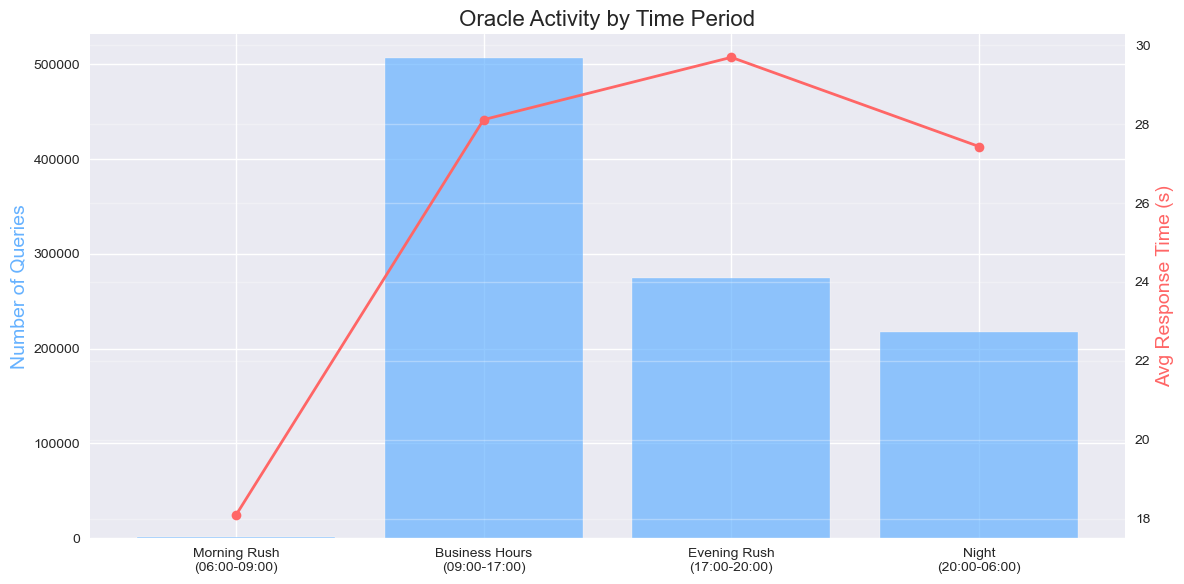

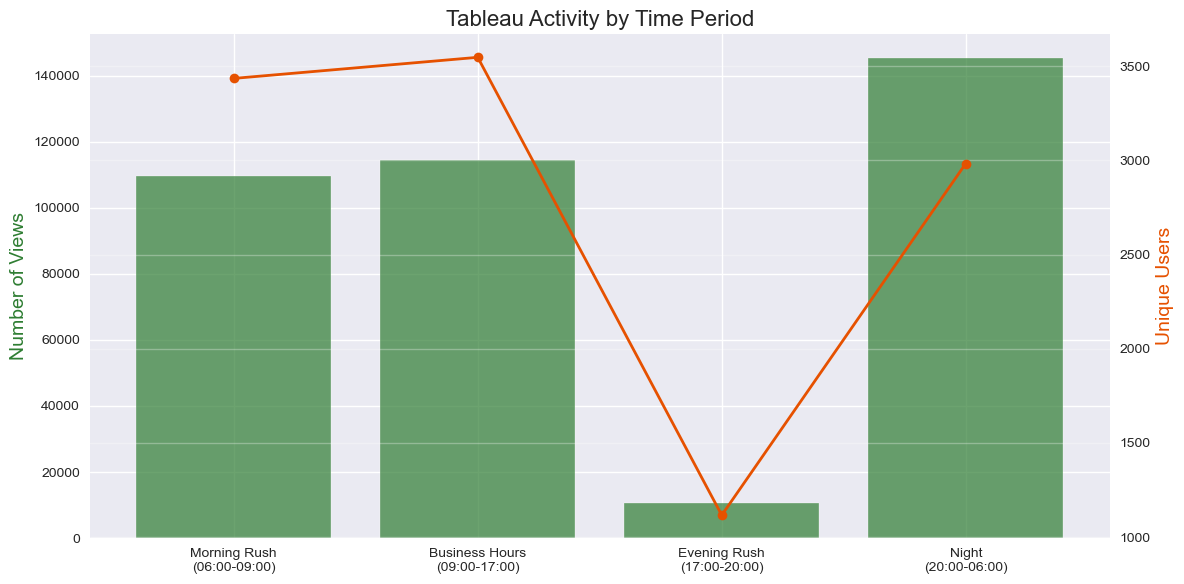

In [15]:
period_analysis = analyze_time_periods(oracle_df, tableau_df)
plot_time_period_analysis(period_analysis)

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

file_path = "newOracle.csv"  # 你的数据文件
df = pd.read_csv(file_path)

df["Start Timestamp"] = pd.to_datetime(df["Start Timestamp"])
df["End Timestamp"] = pd.to_datetime(df["End Timestamp"])

df["Dashboard Page"] = df["Dashboard Page"].fillna(df["Presentation Name"])
df["Dashboard Page"] = df["Dashboard Page"].fillna(df["Query Source Code"])

df = df.sort_values(by=["User Name", "Start Timestamp"])


In [17]:
df["Previous Page"] = df.groupby("User Name")["Dashboard Page"].shift(1)
df["Time Diff"] = df.groupby("User Name")["Start Timestamp"].diff().dt.total_seconds()

df["Hour"] = df["Start Timestamp"].dt.hour

df["Time Period"] = df["Hour"].apply(lambda x: "Morning" if 6 <= x < 18 else "Evening")

df["Active Time (seconds)"] = (df["End Timestamp"] - df["Start Timestamp"]).dt.total_seconds()
user_active_time = df.groupby("User Name")["Active Time (seconds)"].sum()

median_active_time = user_active_time.median()
df["User Type"] = df["User Name"].apply(lambda x: "High Active" if user_active_time[x] > median_active_time else "Low Active")

In [19]:
# Select specific users
user_id = "CL085848"  # can be replaced
user_df = df[df["User Name"] == user_id].copy()

user_df = user_df.sort_values("Start Timestamp")
user_df["Page Duration (seconds)"] = (user_df["End Timestamp"] - user_df["Start Timestamp"]).dt.total_seconds()
print(user_df.head())
print(f"length: {len(user_df)}") 

user_df["Previous Page"] = user_df["Dashboard Page"].shift(1)
user_df["Jump Time (seconds)"] = (user_df["Start Timestamp"] - user_df["Start Timestamp"].shift(1)).dt.total_seconds()

user_df["Previous Page"].fillna("No Previous Page", inplace=True)  
user_df["Jump Time (seconds)"].fillna(0, inplace=True)

morning_df = user_df[user_df["Time Period"] == "Morning"]
evening_df = user_df[user_df["Time Period"] == "Evening"]
high_active_df = user_df[user_df["User Type"] == "High Active"]
low_active_df = user_df[user_df["User Type"] == "Low Active"]


morning_data = user_df[(user_df["Start Timestamp"].dt.hour >= 6) & (user_df["Start Timestamp"].dt.hour < 12)]
night_data = user_df[(user_df["Start Timestamp"].dt.hour >= 18) & (user_df["Start Timestamp"].dt.hour < 24)]
print(f"morning data length : {len(morning_data)}, night data length: {len(night_data)}")

        Total Time in Seconds  Row Count  Response Time in Seconds  \
182364                      0          1                         0   
182365                      1          1                         1   
182516                      0          1                         0   
182518                      5      68345                         3   
182519                      0        580                         0   

        Number of DB Queries  Cumulative Number of DB Rows  \
182364                     1                             1   
182365                     1                             1   
182516                     1                             1   
182518                     1                         68345   
182519                     1                           580   

        Cumulative Database Time in Seconds  Compile Time in Seconds  \
182364                                    0                        0   
182365                                    0                   

In [20]:
def get_page_jumps(df, date):
    date = pd.to_datetime(date).normalize() 

    df_filtered = df[(df["Start Timestamp"].dt.normalize() == date) | (df["End Timestamp"].dt.normalize() == date)]

    return df_filtered.groupby(["Previous Page", "Dashboard Page"]).size().reset_index(name="Jump Count")

date = "2022-11-02"
morning_jumps = get_page_jumps(morning_df, date)
evening_jumps = get_page_jumps(evening_df, date)
high_active_jumps = get_page_jumps(high_active_df, date)
low_active_jumps = get_page_jumps(low_active_df, date)

In [21]:
def plot_user_journey(jump_data, title, color_map):
    G = nx.DiGraph()

    for index, row in jump_data.iterrows():
        G.add_edge(row["Previous Page"], row["Dashboard Page"], weight=row["Jump Count"])

    plt.figure(figsize=(12, 8))  
    pos = nx.spring_layout(G, seed=42, k=0.3) 
    edges = G.edges(data=True)

    edge_weights = [d["weight"] for (_, _, d) in edges]
    max_weight = max(edge_weights) if edge_weights else 1  
    widths = [2 + (w / max_weight) * 5 for w in edge_weights] 

    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color=color_map, width=widths, node_size=1000, font_size=8)
    
    edge_labels = {(u, v): d["weight"] for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(title, fontsize=8)
    plt.show()

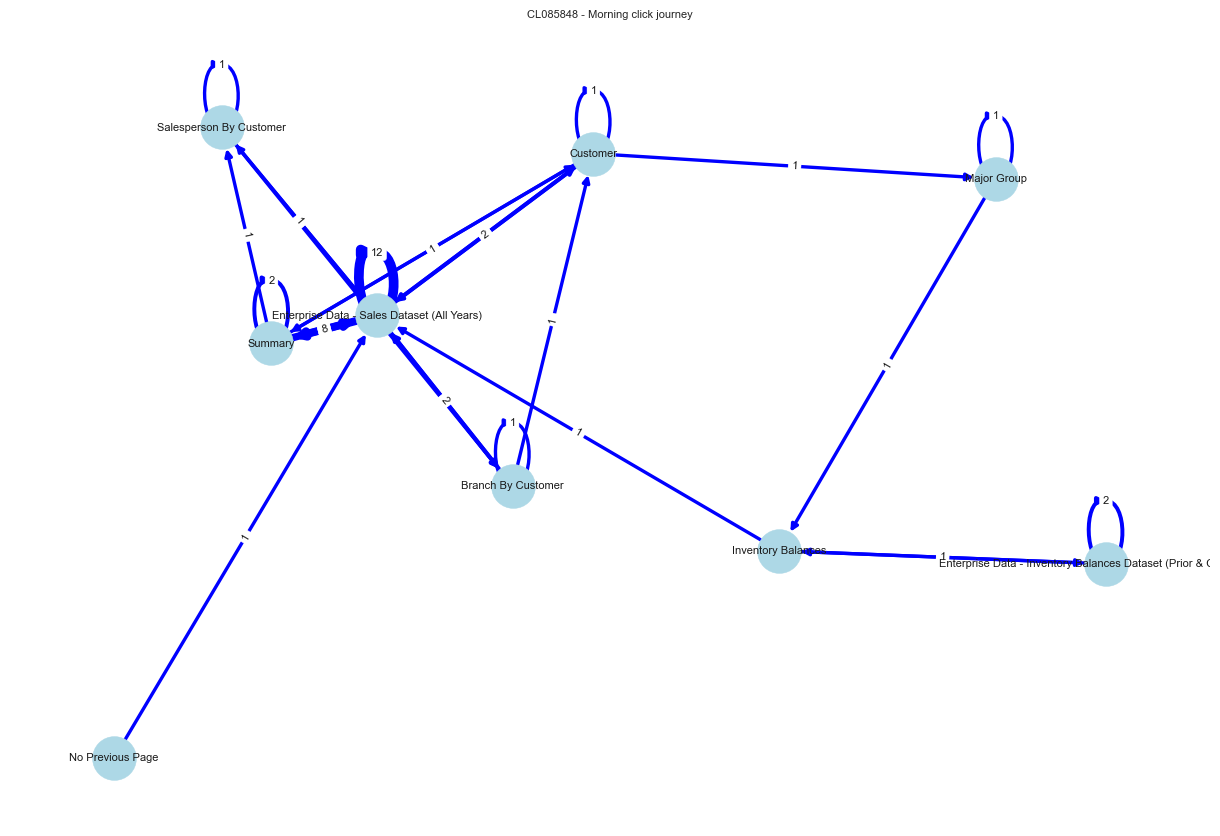

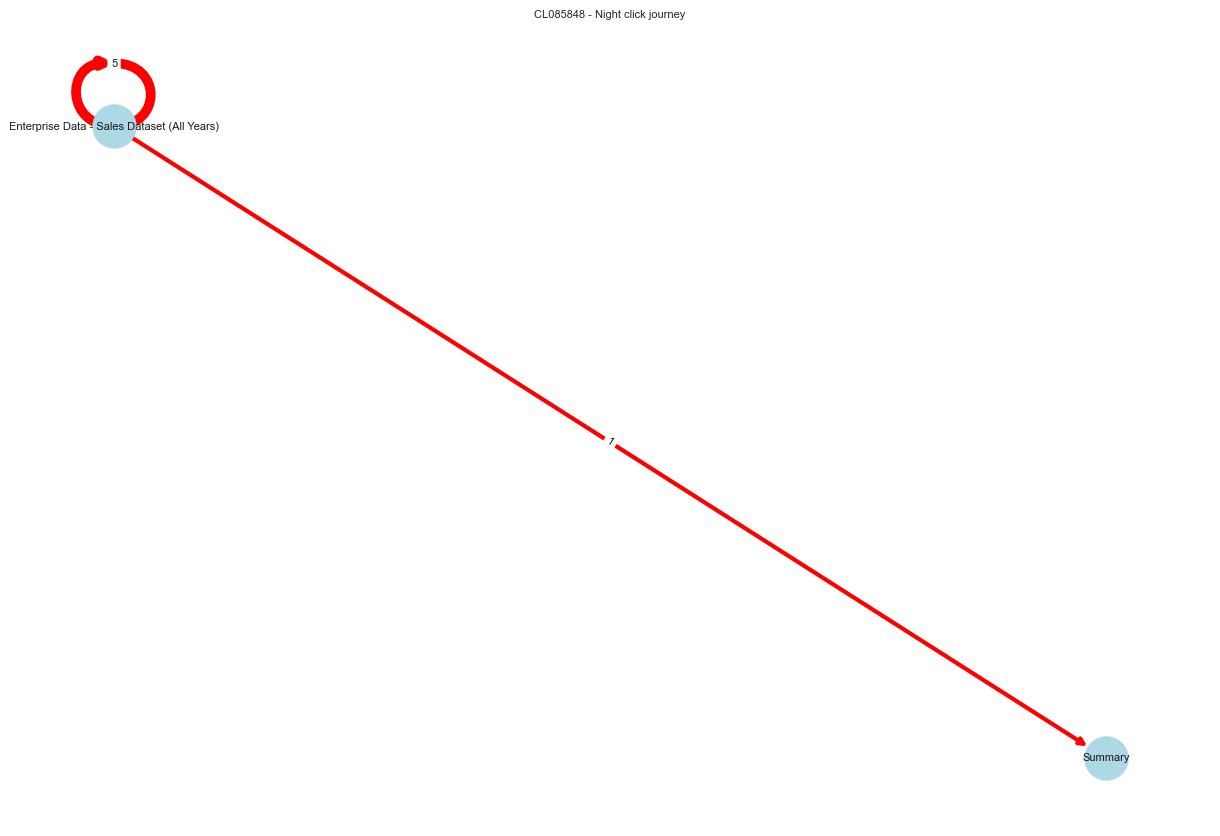

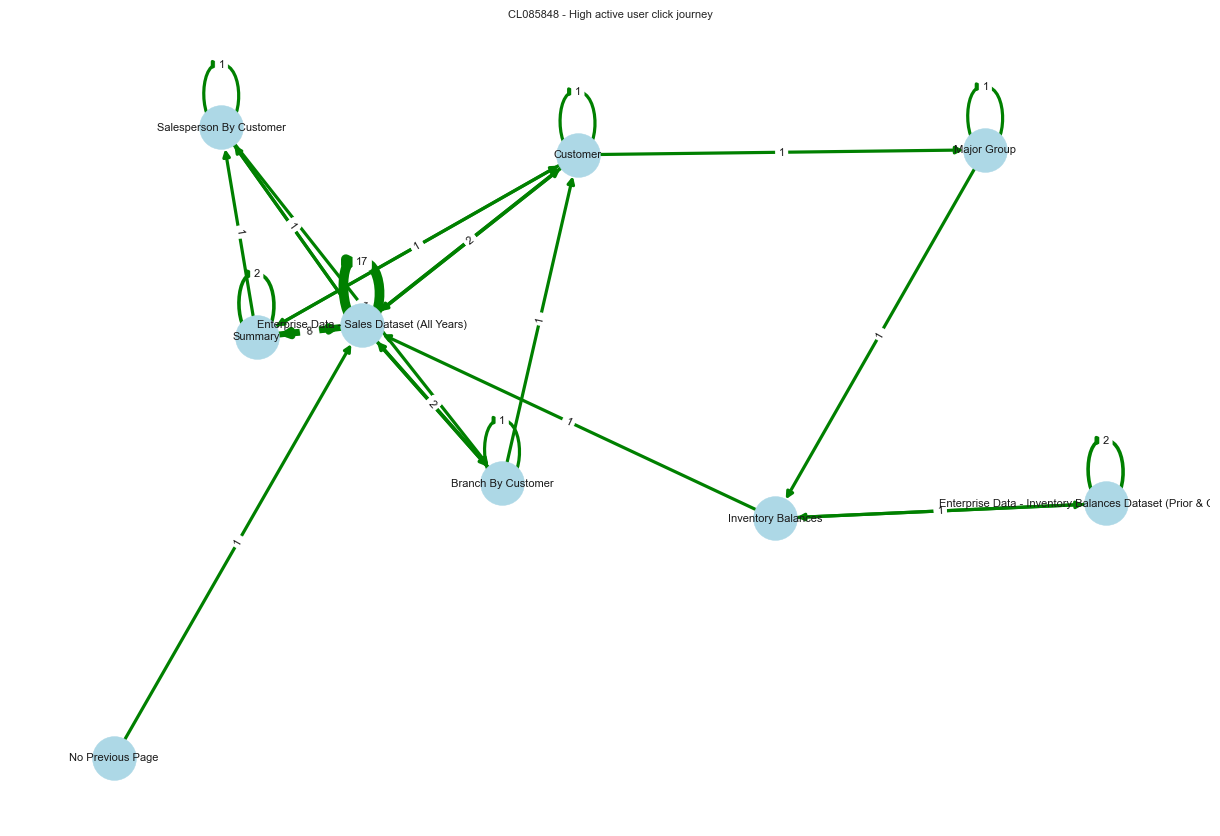

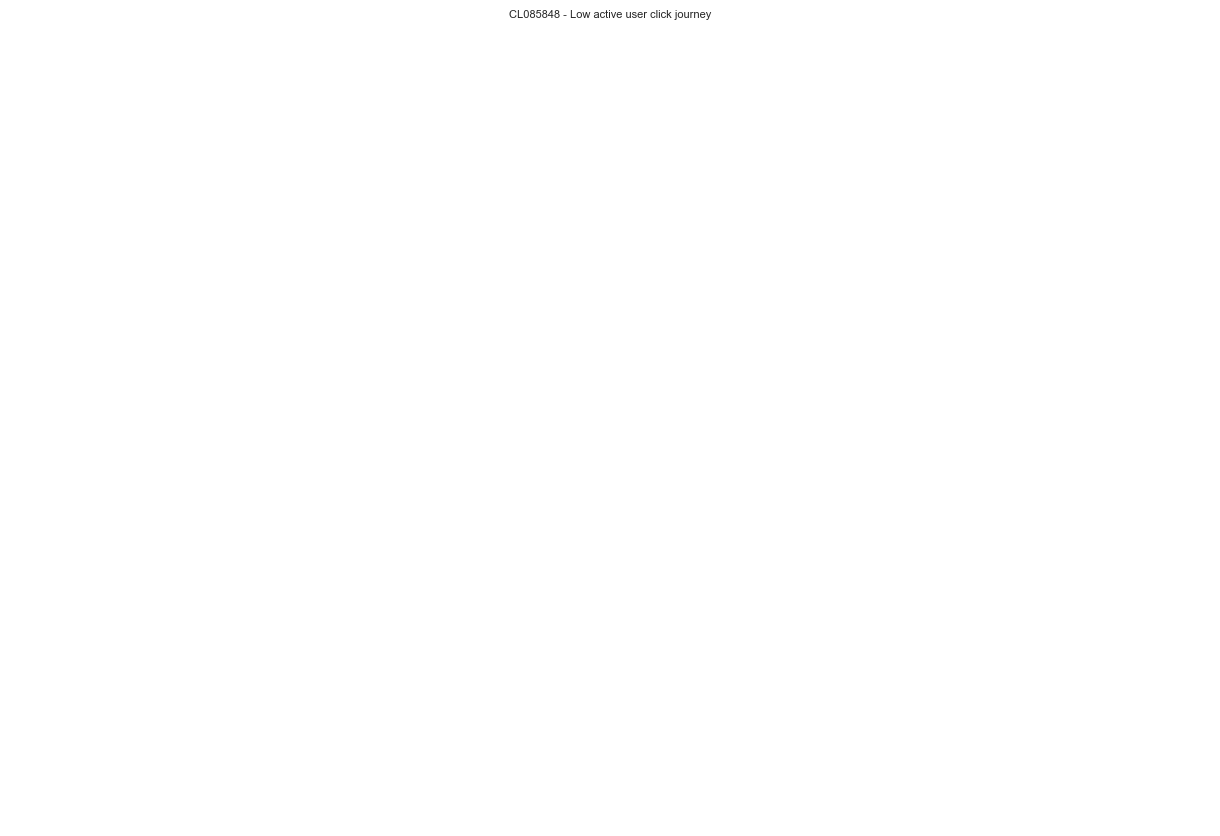

In [22]:
plot_user_journey(morning_jumps, f"{user_id} - Morning click journey", "blue")
plot_user_journey(evening_jumps, f"{user_id} - Night click journey", "red")
plot_user_journey(high_active_jumps, f"{user_id} - High active user click journey", "green")
plot_user_journey(low_active_jumps, f"{user_id} - Low active user click journey", "gray")
